In [1]:
import shutil
import os

import hashlib
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import cv2

### Nueva carpeta sin las fotos duplicadas


In [2]:
# Duplicamos la carpeta
import shutil
import os

def duplicar_carpeta(origen, destino):
    if os.path.exists(destino):
        shutil.rmtree(destino)
    shutil.copytree(origen, destino)

# Duplicar la carpeta "Celebrity Faces Dataset"
duplicar_carpeta('../Celebrity Faces Dataset', '../Celebrity_Faces_Dataset_Duplicada')

### Lista imagenes repetidas

In [3]:
import hashlib
import os
from collections import defaultdict


def calcular_hash_imagen(image_path):
    """Calcula el hash MD5 de una imagen."""
    with open(image_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

def encontrar_imagenes_duplicadas(directorio):
    """
    Encuentra imágenes duplicadas en un directorio dado.
    Esta función recorre recursivamente un directorio y calcula el hash de cada imagen
    (archivos con extensiones .jpg, .jpeg, .png). Luego, agrupa las imágenes por su hash
    y devuelve un diccionario con los hashes como claves y listas de rutas de archivos
    como valores, donde cada lista contiene las rutas de las imágenes duplicadas.
    Args:
        directorio (str): La ruta del directorio en el que buscar imágenes duplicadas.
    Returns:
        dict: Un diccionario donde las claves son los hashes de las imágenes y los valores
              son listas de rutas de archivos que corresponden a imágenes duplicadas.
    """
    hashes = defaultdict(list)
    for root, dirs, files in os.walk(directorio):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, file)
                file_hash = calcular_hash_imagen(file_path)
                hashes[file_hash].append(file_path)
    
    duplicados = {hash: paths for hash, paths in hashes.items() if len(paths) > 1}
    return duplicados

In [4]:
diccionario_repetidas = encontrar_imagenes_duplicadas('../Celebrity_Faces_Dataset_Duplicada')

### Eliminar las repetidas

In [5]:
def eliminar_imagenes_duplicadas(diccionario_repetidas):
    for hash, paths in diccionario_repetidas.items():
        # Mantener la primera imagen y eliminar las demás duplicadas
        for path in paths[1:]:
            os.remove(path)

# Eliminar las imágenes duplicadas de la carpeta duplicada
eliminar_imagenes_duplicadas(diccionario_repetidas)

Verificamos

In [7]:
# Directorios
dataset_dir = "../Celebrity_Faces_Dataset_Duplicada"

# Encontrar imágenes duplicadas en cada directorio
duplicados = encontrar_imagenes_duplicadas(dataset_dir)

# Numero de imagenes duplicadas
num_duplicados = sum(len(paths) - 1 for paths in duplicados.values())

print(f"Número de imágenes duplicadas: {num_duplicados}")


Número de imágenes duplicadas: 0


In [10]:


def contar_imagenes_por_clase(directorio):
    conteo_clases = defaultdict(int)
    for root, dirs, files in os.walk(directorio):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                clase = os.path.basename(root)
                conteo_clases[clase] += 1
    return conteo_clases

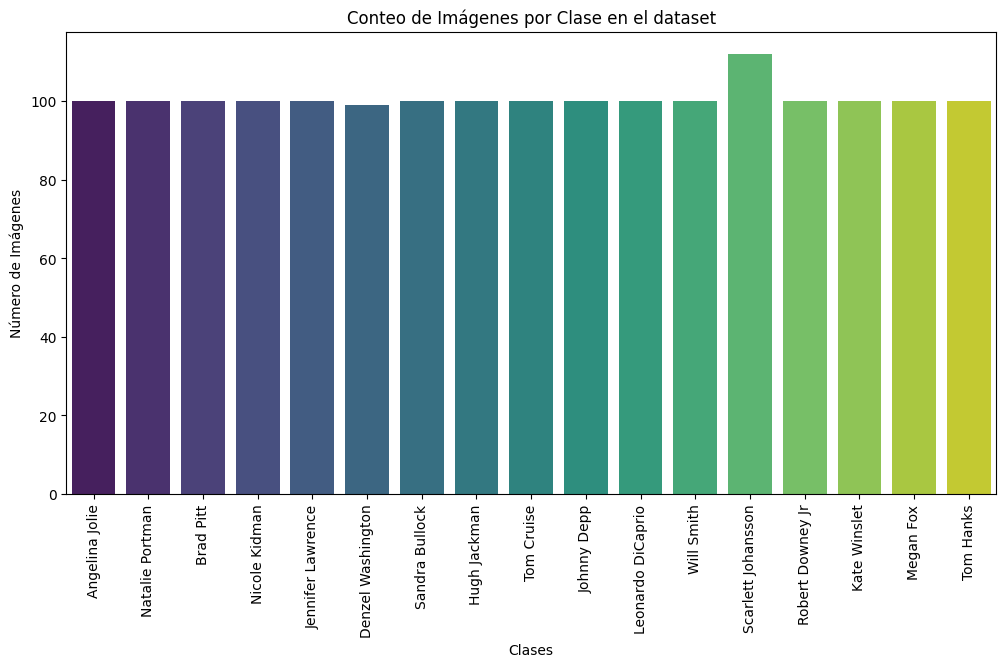

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_conteo_imagenes(conteo, titulo):
    clases = list(conteo.keys())
    conteos = list(conteo.values())
    colors = sns.color_palette('viridis', len(clases))  # Convertir la paleta a una lista

    plt.figure(figsize=(12, 6))
    sns.barplot(x=clases, y=conteos, palette=colors, hue=clases, dodge=False)
    plt.xlabel('Clases')
    plt.ylabel('Número de Imágenes')
    plt.title(titulo)
    plt.xticks(rotation=90)  # Rotar las etiquetas del eje x a 90 grados (vertical)
    plt.legend([],[], frameon=False)  # Ocultar la leyenda
    plt.show()

data_dir = "../Celebrity_Faces_Dataset_Duplicada"

conteo_dataset = contar_imagenes_por_clase(data_dir)

plot_conteo_imagenes(conteo_dataset, "Conteo de Imágenes por Clase en el dataset")

### Añadir padding a las imagenes para que todas tengan un AR de 1

In [14]:
import numpy as np
import cv2

In [15]:
def calcular_estadisticas_dimensiones(directorio):
    anchos = []
    altos = []
    
    for root, dirs, files in os.walk(directorio):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, file)
                img = cv2.imread(file_path)
                if img is not None:
                    alto, ancho, _ = img.shape
                    anchos.append(ancho)
                    altos.append(alto)
    
    if not anchos or not altos:
        return {
            'ancho': {'max': 0, 'min': 0, 'media': 0, 'std': 0},
            'alto': {'max': 0, 'min': 0, 'media': 0, 'std': 0}
        }
    
    estadisticas = {
        'ancho': {
            'max': np.max(anchos),
            'min': np.min(anchos),
            'media': np.mean(anchos),
            'std': np.std(anchos)
        },
        'alto': {
            'max': np.max(altos),
            'min': np.min(altos),
            'media': np.mean(altos),
            'std': np.std(altos)
        }
    }
    
    return estadisticas

In [16]:

# Ajustar aspect ratio de las imágenes a 1 añadiendo padding

def ajustar_aspect_ratio(imagen, aspect_ratio_objetivo=1.0):
    alto, ancho, _ = imagen.shape
    aspect_ratio = ancho / alto

    if aspect_ratio > aspect_ratio_objetivo:
        # La imagen es más ancha que alta, añadir padding vertical
        nuevo_alto = int(ancho / aspect_ratio_objetivo)
        margen = nuevo_alto - alto
        margen_superior = margen // 2
        margen_inferior = margen - margen_superior
        imagen = cv2.copyMakeBorder(imagen, margen_superior, margen_inferior, 0, 0, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    elif aspect_ratio < aspect_ratio_objetivo:
        # La imagen es más alta que ancha, añadir padding horizontal
        nuevo_ancho = int(alto * aspect_ratio_objetivo)
        margen = nuevo_ancho - ancho
        margen_izquierdo = margen // 2
        margen_derecho = margen - margen_izquierdo
        imagen = cv2.copyMakeBorder(imagen, 0, 0, margen_izquierdo, margen_derecho, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    
    return imagen

In [17]:
# Directorio del dataset
dataset_dir = "../Celebrity_Faces_Dataset_Duplicada"

# ajustar aspect ratio de las imágenes en el dataset
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            file_path = os.path.join(root, file)
            img = cv2.imread(file_path)
            if img is not None:
                img = ajustar_aspect_ratio(img)
                cv2.imwrite(file_path, img)


In [18]:
# comprovar con la media y la desviación estandar
estadisticas_dimensiones = calcular_estadisticas_dimensiones(dataset_dir)
print(f"Estadísticas de las ancho:\n{estadisticas_dimensiones.get('ancho')}")
print(f"Estadísticas de las alto:\n{estadisticas_dimensiones.get('alto')}")


Estadísticas de las ancho:
{'max': np.int64(592), 'min': np.int64(160), 'media': np.float64(501.7264757451783), 'std': np.float64(93.00198269239105)}
Estadísticas de las alto:
{'max': np.int64(592), 'min': np.int64(160), 'media': np.float64(501.7264757451783), 'std': np.float64(93.00198269239105)}
